## Université Paris-Sud 
## Info 114 Introduction to Data Science -- Fall 2019
# Project 5: BIAS IN DATA

In this project you will try to find biases in the apple and banana dataset by analyzing the metadata. The metadata records information about how data samples were collected: when, where, in which lighting conditions, etc. This is what we call "meta-features". Can you predict "apple" vs. "banana" based on these meta-features? This would allow you to identify a potential "confounding factor".

In [1]:
# Load general libraries
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from sys import path

In [2]:
# Import the instructors' utilities
code_dir = '../utilities'
path.append(code_dir); 
from utilities import *
# ... and YOUR OWN functions (you will have to edit the file mycode.py)
from mycode import *

## Step 1: Loading metadata
The metadata is a CSV (comma separated) file, which can be loaded as a Pandas dataframe `df`.

In [3]:
meta_data_dir = '../mini-dataset/meta-data'
metadata = pd.read_csv(os.path.join(meta_data_dir, 'metadata.csv'))
metadata.head()

,Num,File,Subset,Fruit,Color,Count,DateTime,GPSAltitude,GPSLatitude,GPSLongitude>,GPSImgDirection,GPSDestBearing,ShutterSpeedValue,SubsecTimeDigitized,ExposureTime,BrightnessValue
0,1,IMG_3521.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-19 17:39:45,334.0,37;53.7857N,122;15.5356W,356238/1463,356238/1463,84572/17235,944,1/30,5396/1247
1,2,IMG_2818.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 08:48:17,327.0,37;53.7943N,122;15.5461W,2224375/16003,2277333/16384,84572/17235,510,1/30,19223/5070
2,3,IMG_4313.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-21 09:36:05,313.0,37;53.7997N,122;15.5736W,352652/1409,352652/1409,49625/8401,213,1/60,59991/11077
3,4,IMG_2819.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 08:48:20,327.0,37;53.7943N,122;15.5461W,49647/394,49647/394,84572/17235,72,1/30,159250/38599
4,5,IMG_2953.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 09:03:13,330.0,37;53.796N,122;15.5511W,389855/1317,389855/1317,84572/17235,935,1/30,26857/12851


The metadata we provide use includes information about a large dataset of fruits. In class we analyzed only images containing a single apple or banana. So we first select only those items in the metadata. We check that we get the correct number of samples corresponding to the data we studied in class.

In [4]:
# Select images with a single apple or banana
is_apple = metadata['Fruit']=='APPLE'
is_banana = metadata['Fruit']=='BANANA'
count_one = metadata['Count']=='1-ONE'
apple_subset = metadata[is_apple & count_one]
banana_subset = metadata[is_banana & count_one]
print('Apples: {}'.format(apple_subset.shape))
print('Bananas: {}'.format(banana_subset.shape))

Apples: (333, 16)
Bananas: (158, 16)


## Step 2: Preprocessing metadata
### Converting categorical variables to numerical

The `describe` method of Pandas allows you to view statistics on the NUMERICAL variables only. This dataset contains many CATEGORICAL variables (encoded as strings). One of your tasks will be to first convert categorical variables to numerical variables. 

<a href ="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html">This post from the pandas library</a> may not be the best solution. Read also <a href ="https://www.kaggle.com/c/titanic/discussion/5379"> this Kaggle discussion</a> abd 
<a href ="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder"> this scikit-learn suggestion</a>. By searching on the Internet, you may find yet better solutions.


In [5]:
metadata.describe()

,Num,GPSAltitude,SubsecTimeDigitized
count,1534.000000,1533.000000,1534.000000
mean,767.500000,328.069145,496.718383
std,442.971971,20.513714,290.339883
min,1.000000,49.000000,0.000000
25%,384.250000,329.000000,246.000000
50%,767.500000,330.000000,481.500000
75%,1150.750000,333.000000,758.750000
max,1534.000000,344.000000,996.000000


For illustration, we show you what can be done with meta-features using only the two numerical features we have identified.

In [6]:
series = ['Num', 'GPSAltitude', 'SubsecTimeDigitized']
metadata_subset = apple_subset.copy()[series]
metadata_subset = metadata_subset.append(banana_subset.copy()[series])
na = len(apple_subset)
nb = len(banana_subset)
Y = np.append(np.ones([na, 1]), -1*np.ones([nb, 1]))
metadata_subset['fruit'] = Y
metadata_subset.head()

,Num,GPSAltitude,SubsecTimeDigitized,fruit
775,776,334.0,106,1.0
776,777,331.0,178,1.0
777,778,327.0,917,1.0
778,779,328.0,342,1.0
779,780,329.0,252,1.0


### Replacing missing values

Sometimes datasets have missing values, encoded as NaN. This is a problem for some data science (or machine learning) algorithms (or methods). If there are many missing values, you should investigate proper techniques to replace them. Here we just replace them by zero because there are very few (actually only one).

In [7]:
# Finde whether there are missing values
na_val = check_na(metadata_subset)

     GPSAltitude
895          NaN


In [8]:
# Replace missing values by zero
metadata_subset[metadata_subset.isna()]=0

In [9]:
# Check that we got rid of the missing values
check_na(metadata_subset)

Empty DataFrame
Columns: []
Index: []


""


## Step 3: Visualizing data
Here take some of the suggestions given in class to visualize data (heatmaps, scatter plots, etc.)

## Step 4: Predicting the target
Now we try to predict the target value (apple or banana) from the meta-features using the 3-nearest neighbor classifier.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
sklearn_model = KNeighborsClassifier(n_neighbors=3)

In [11]:
p_tr, s_tr, p_te, s_te = df_cross_validate(metadata_subset, sklearn_model, sklearn_metric, n=10, verbose=False)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr, s_tr))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te, s_te))

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 0.99 +- 0.01
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.97 +- 0.02


Shockingly, we predict the separation with 97% accuracy on test data. There is definitly a problem of bias in data that you should investigate.

## Step 6: Interpreting the results

Below is an image of the whole dataset. Can you understand what could be a potential confounding factor?

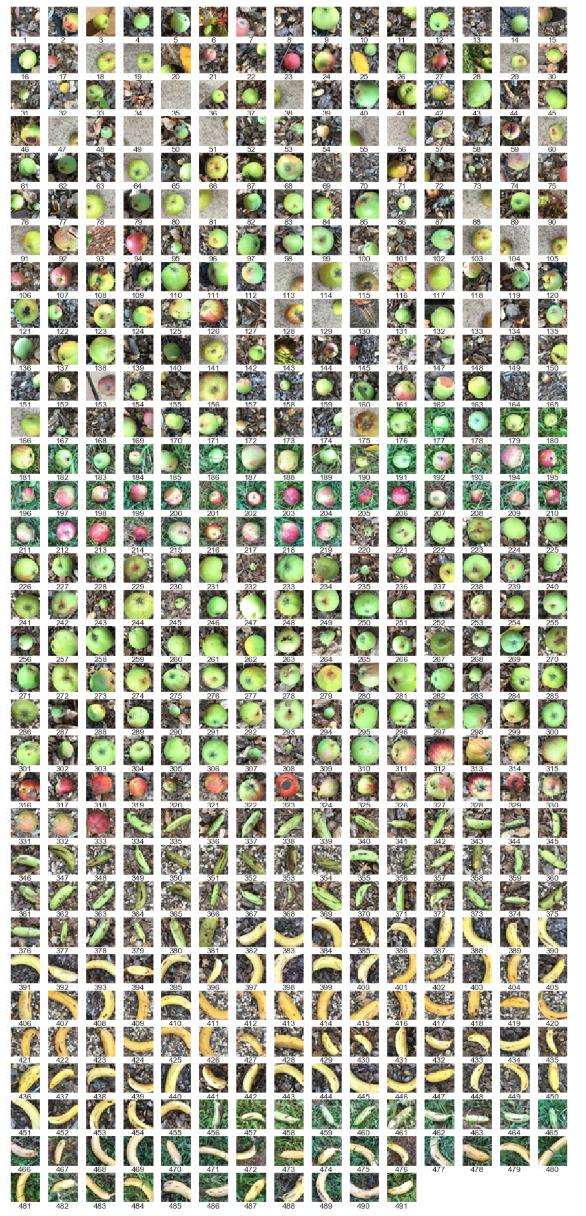

In [12]:
img = get_image(os.path.join(meta_data_dir, 'all_data.png'))
img

## Step 7: Identifying the confounding factor
Can you check your hypothesis by restricting your feature set to the most suspicious factor and doing the prediction with nearest neighbors again? 

## Step 8: Correcting bias
Suggest ways of modifying the dataset to correct the bias(es).

# Conclusion
Always end with some conclusion. What did you learn? What could be improved?

## ALWAYS TERMINATE YOUR WORK WITH "RESTART AND RUN ALL".